# Exploratory Data Analysis 
---
*Disclaimer: This notebook contains text that is profound, vulgar, and offensive due to the nature of the dataset.*

We live in an age where people's lives have become intertwined with their online presence allowing humans to engage with one another on a larger scale than ever before.  However, not all of these interactions foster growth.  People exploit the fact that their identity remains hidden and choose to target one another with unwarranted abuse causing harm instead of growth.  For our society to truly prosper from the digital age we have to combat this toxic behavior.  This will enable more and more people who are scared of what other people will think when they post on social media to engage freely without the fear of being the target of online hate.  

Our task is to improve civility on social media platforms (e.g., Twitter) and online comment forums (e.g., Reddit) by training a model that determines how likely a users comment will make another user leave a conversation.  With our model, we will create a web application that tracks how toxic each social media platform and online comment forum is to bring awareness to this issue and spark initiative to create a toxic free environment for all users.  

This issue can only be solved with the help of everyone by encouraging kindness instead of spreading hate.

## Data Description
The dataset used in this project is from the kaggle competition: [Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

In 2017 the Civil Comments platform shutdown and released their archive of ~2 million public comments for researchers to study in an effort to improve civility online. Jigsaw funded the annotation of this data by human raters. 

The column `toxicity` is our toxicity label which contains a number between 0-1 denoting the fraction of human labelers that believed the comment would make someone else leave a conversation. 

For our analysis we'll define the comment as toxic (denoted 1) when the value of our target `toxicity` is greater than or equal to 0.5 otherwise we'll assign the instance to the negative class (denoted 0).

There are a lot of additional labels denoting the fraction of human labelers who believed the comment depicted several other sub-toxic labels and whether specific identity groups were mentioned in the comment. These columns will be **removed** from our analysis because we will not have access to this data in the production environment.

### Labeling Schema
As mentioned on Kaggle, each comment was shown to up to 10 human labelers.  The labelers were asked to rate how toxic each comment is. 
* Very Toxic
* Toxic
* Hard to Say
* Not Toxic

The ratings were then aggragated into the `target` column.

*Note: Some comments were shown to more than 10 human labelers because of sampling strategies to increase rating accuracy.*

In [11]:
import matplotlib.pyplot as plt
import os
import pandas as pd

import nltk
from sklearn.model_selection import train_test_split
import tensorflow as tf
import textblob
import wordcloud

# Root directory used to navigate tree.
PROJECT_ROOT_DIR = os.path.dirname(os.getcwd())

# Path to save images and figures.
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "reports/figures")
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Saves figures in toxic_media/reports/figures.
    
    Parameters
    ----------
    fig_id : str
        Name of the figure to be saved.
    tight_layout : bool, default=True
        Enables padding between figure edge and edges of subplots when set to True.
    fig_extension : {'jpg', 'png', 'svg'}, default='png'
        Figure format.
    resolution : int
        Figure resolution.
    """
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print(f"Saving figure: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Load Data
We're going to start by loading the raw data to get a quick look at it before creating a training set with which we'll use to explore in-depth. As mentioned above, the initial data file has extra columns we will not be using.  Therefore, we'll only load in the target column and the comment text. 

In [12]:
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")

def load_data(path="raw/all_data.csv"):
    """
    Load data into pandas dataframe object.
    
    Parameters
    ----------
    path : str, default=raw/all_data.csv
        Directory and filename in format 'directory/filename.csv'.
    """
    csv_path = os.path.join(DATA_DIR, path)
    
    return pd.read_csv(csv_path, usecols=['comment_text', 'toxicity'])

In [13]:
toxic = load_data()

In [14]:
toxic.head()

,comment_text,toxicity
0,He got his money... now he lies in wait till a...,0.373134
1,Mad dog will surely put the liberals in mental...,0.605263
2,And Trump continues his lifelong cowardice by ...,0.666667
3,"""while arresting a man for resisting arrest"".\...",0.815789
4,Tucker and Paul are both total bad ass mofo's.,0.550000


In [15]:
toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999516 entries, 0 to 1999515
Data columns (total 2 columns):
 #   Column        Dtype  
---  ------        -----  
 0   comment_text  object 
 1   toxicity      float64
dtypes: float64(1), object(1)
memory usage: 30.5+ MB


In [16]:
toxic.isnull().sum() / len(toxic)

comment_text    5.001210e-07
toxicity        0.000000e+00
dtype: float64

In [19]:
toxic.describe()

,toxicity
count,1.999516e+06
mean,1.029241e-01
std,1.970386e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.666667e-01
max,1.000000e+00


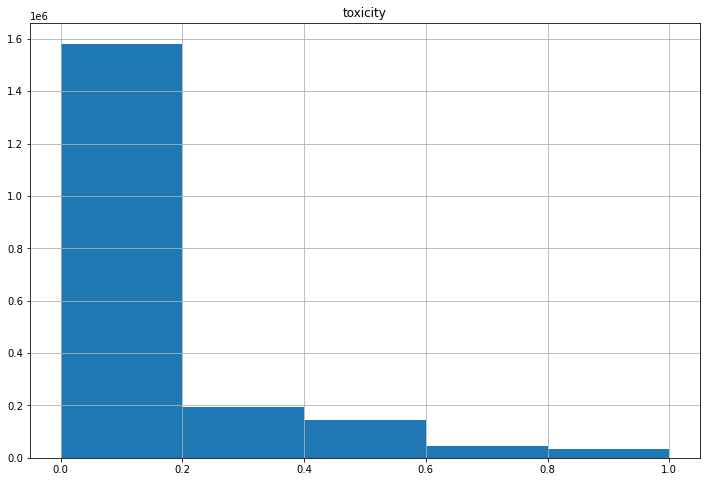

In [25]:
toxic.hist(bins=5, figsize=(12, 8))
plt.show()

### Summary
After our initial look into the data we found a few things to take note of:
* We're missing text in a few instances.
* Our target column `toxicity` is heavily skewed towards 0 meaning we'll have to deal with class imbalance when it comes to modeling.
* There were a good amount of instances labeled around 0.5 that might be hard to predict.  It seems the labelers were not in agreement whether the comment was toxic.

## Test Set